# pip & import

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163489 sha256=20f3110a27b1885d9720e6a065823b3e99c8abb90e7bdf96c854a219a996b904
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import category_encoders as ce
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.dataset import DatasetAutoFolds
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 가공 및 변환

In [ ]:
apply_train_df = pd.read_csv('apply_train.csv')
resume_train_df = pd.read_csv('resume.csv')
certificate_df = pd.read_csv('resume_certificate.csv')
education_train_df = pd.read_csv('resume_education.csv')
language_train_df = pd.read_csv('resume_language.csv')
company_train_df = pd.read_csv('company.csv')
recruitment_train_df = pd.read_csv('recruitment.csv')

In [ ]:
count_by_recruitment_seq = apply_train_df.groupby('recruitment_seq')['resume_seq'].count()
count_by_recruitment_seq = count_by_recruitment_seq.reset_index()
count_by_recruitment_seq.columns = ['recruitment_seq', 'rating']

# 업데이트된 DataFrame을 확인합니다.
count_by_recruitment_seq

recruitment_seq  rating
0             R00001      11
1             R00002       6
2             R00003       7
3             R00004      15
4             R00005       5
...              ...     ...
6690          R06691       6
6691          R06692      11
6692          R06693       4
6693          R06694       7
6694          R06695       9

[6695 rows x 2 columns]

In [ ]:
total_user = resume_train_df.sort_values(by='resume_seq')
certificate_df = certificate_df.dropna(subset=['certificate_contents'])
tmp = certificate_df.groupby('resume_seq')['certificate_contents'].apply(';'.join).reset_index()
total_user = pd.merge(total_user, tmp, on='resume_seq', how='left')
total_user = pd.merge(total_user, education_train_df, on='resume_seq', how='left')
total_user = pd.merge(total_user, apply_train_df, on='resume_seq', how='left')

In [ ]:
total_user

resume_seq    reg_date updated_date  degree  graduate_date  hope_salary  \
0         U00001  2019-12-27   2020-02-01       4           2009       1500.0   
1         U00001  2019-12-27   2020-02-01       4           2009       1500.0   
2         U00001  2019-12-27   2020-02-01       4           2009       1500.0   
3         U00001  2019-12-27   2020-02-01       4           2009       1500.0   
4         U00002  2020-04-24   2020-04-29       4           2005          0.0   
...          ...         ...          ...     ...            ...          ...   
57941     U08481  2020-07-09   2020-11-23       4           2015          0.0   
57942     U08481  2020-07-09   2020-11-23       4           2015          0.0   
57943     U08482  2020-11-29   2020-11-29       4              0          0.0   
57944     U08482  2020-11-29   2020-11-29       4              0          0.0   
57945     U08482  2020-11-29   2020-11-29       4              0          0.0   

       last_salary                 text_keyword job_code_seq1 job_code_seq2  \
0           1500.0                         디자이너   재료·화학·섬유·의복           NaN   
1           1500.0                         디자이너   재료·화학·섬유·의복           NaN   
2           1500.0                         디자이너   재료·화학·섬유·의복           NaN   
3           1500.0                         디자이너   재료·화학·섬유·의복           NaN   
4              0.0                         디자이너   재료·화학·섬유·의복           NaN   
...            ...                          ...           ...           ...   
57941       2700.0              상품기획;머천다이저;기획MD   재료·화학·섬유·의복           NaN   
57942       2700.0              상품기획;머천다이저;기획MD   재료·화학·섬유·의복           NaN   
57943          0.0  상품기획;영업MD;머천다이저;기획MD;마케팅;PR   재료·화학·섬유·의복           NaN   
57944          0.0  상품기획;영업MD;머천다이저;기획MD;마케팅;PR   재료·화학·섬유·의복           NaN   
57945          0.0  상품기획;영업MD;머천다이저;기획MD;마케팅;PR   재료·화학·섬유·의복           NaN   

       ... hischool_location_seq  univ_type_seq1 univ_type_seq2 univ_transfer  \
0      ...                     4               5              5             0   
1      ...                     4               5              5             0   
2      ...                     4               5              5             0   
3      ...                     4               5              5             0   
4      ...                     0               5              5             0   
...    ...                   ...             ...            ...           ...   
57941  ...                     5               5              5             0   
57942  ...                     5               5              5             0   
57943  ...                     8               0              0             0   
57944  ...                     8               0              0             0   
57945  ...                     8               0              0             0   

       univ_location univ_major univ_sub_major univ_major_type  univ_score  \
0                 17        NaN            NaN               9        20.0   
1                 17        NaN            NaN               9        20.0   
2                 17        NaN            NaN               9        20.0   
3                 17        NaN            NaN               9        20.0   
4                  3        NaN            NaN               8        90.0   
...              ...        ...            ...             ...         ...   
57941              5        NaN            NaN               9        60.0   
57942              5        NaN            NaN               9        60.0   
57943              0        NaN            NaN               9        80.0   
57944              0        NaN            NaN               9        80.0   
57945              0        NaN            NaN               9        80.0   

       recruitment_seq  
0               R05288  
1               R05210  
2               R06065  
3               R04536  
4               R06019  
...                ...  

In [ ]:
total_item = recruitment_train_df
total_item = pd.merge(total_item, company_train_df, on='recruitment_seq', how='left')
total_item = pd.merge(total_item, count_by_recruitment_seq, on='recruitment_seq', how='left')
total_item

recruitment_seq  address_seq1  address_seq2  address_seq3  career_end  \
0             R02264           3.0           NaN           NaN           0   
1             R06317           3.0           NaN           NaN           0   
2             R04017           3.0           NaN           NaN           0   
3             R02865           3.0           NaN           NaN           0   
4             R04890           3.0           NaN           NaN           0   
...              ...           ...           ...           ...         ...   
6690          R03678           3.0           NaN           NaN           0   
6691          R04593           3.0           NaN           NaN           0   
6692          R03252           3.0           NaN           NaN           0   
6693          R05130           3.0           NaN           NaN           0   
6694          R04779           3.0           NaN           NaN           0   

      career_start              check_box_keyword  education  major_task  \
0                0                 2507;2707;2810          4           8   
1                0                 2204;2205;2707          3           2   
2                0            2101;2108;2201;2707          3           2   
3                0            2201;2204;2205;2707          2           2   
4                0            2201;2204;2205;2707          2           2   
...            ...                            ...        ...         ...   
6690             0  2101;2108;2201;2204;2205;2707          3           2   
6691             0            2201;2204;2205;2707          4           2   
6692             0                           2109          3           2   
6693             0            2201;2204;2205;2707          2           2   
6694             0            2101;2108;2201;2707          3           8   

      qualifications text_keyword  company_type_seq  supply_kind  employee  \
0                  1          NaN               5.0        402.0     800.0   
1                  1          NaN               NaN          NaN       NaN   
2                  1          NaN               NaN          NaN       NaN   
3                  1          NaN               NaN          NaN       NaN   
4                  2          NaN               NaN          NaN       NaN   
...              ...          ...               ...          ...       ...   
6690               1          NaN               NaN          NaN       NaN   
6691               1          NaN               NaN          NaN       NaN   
6692               1          NaN               4.0        402.0     525.0   
6693               2          NaN               2.0        402.0      40.0   
6694               1          NaN               2.0        402.0      41.0   

      rating  
0         14  
1          7  
2          3  
3          5  
4          4  
...      ...  
6690      34  
6691      12  
6692       7  
6693       6  
6694       8  

[6695 rows x 15 columns]

In [ ]:
total = pd.merge(total_user, total_item, on='recruitment_seq', how='left')
total

resume_seq    reg_date updated_date  degree  graduate_date  hope_salary  \
0         U00001  2019-12-27   2020-02-01       4           2009       1500.0   
1         U00001  2019-12-27   2020-02-01       4           2009       1500.0   
2         U00001  2019-12-27   2020-02-01       4           2009       1500.0   
3         U00001  2019-12-27   2020-02-01       4           2009       1500.0   
4         U00002  2020-04-24   2020-04-29       4           2005          0.0   
...          ...         ...          ...     ...            ...          ...   
57941     U08481  2020-07-09   2020-11-23       4           2015          0.0   
57942     U08481  2020-07-09   2020-11-23       4           2015          0.0   
57943     U08482  2020-11-29   2020-11-29       4              0          0.0   
57944     U08482  2020-11-29   2020-11-29       4              0          0.0   
57945     U08482  2020-11-29   2020-11-29       4              0          0.0   

       last_salary               text_keyword_x job_code_seq1 job_code_seq2  \
0           1500.0                         디자이너   재료·화학·섬유·의복           NaN   
1           1500.0                         디자이너   재료·화학·섬유·의복           NaN   
2           1500.0                         디자이너   재료·화학·섬유·의복           NaN   
3           1500.0                         디자이너   재료·화학·섬유·의복           NaN   
4              0.0                         디자이너   재료·화학·섬유·의복           NaN   
...            ...                          ...           ...           ...   
57941       2700.0              상품기획;머천다이저;기획MD   재료·화학·섬유·의복           NaN   
57942       2700.0              상품기획;머천다이저;기획MD   재료·화학·섬유·의복           NaN   
57943          0.0  상품기획;영업MD;머천다이저;기획MD;마케팅;PR   재료·화학·섬유·의복           NaN   
57944          0.0  상품기획;영업MD;머천다이저;기획MD;마케팅;PR   재료·화학·섬유·의복           NaN   
57945          0.0  상품기획;영업MD;머천다이저;기획MD;마케팅;PR   재료·화학·섬유·의복           NaN   

       ... career_start                                  check_box_keyword  \
0      ...            0                                               2507   
1      ...            0                                          2507;2707   
2      ...            0                                               2507   
3      ...            0                                     2507;2707;2799   
4      ...            0                                          2707;2507   
...    ...          ...                                                ...   
57941  ...            0                                2101;2108;2201;2707   
57942  ...            0                                2101;2108;2201;2707   
57943  ...            0                                2101;2108;2201;2707   
57944  ...            0  2101;2108;2109;2201;2203;2204;2205;2302;2507;2707   
57945  ...            0                      2101;2108;2201;2204;2205;2707   

      education major_task  qualifications text_keyword_y company_type_seq  \
0             4          7               1            NaN              NaN   
1             3          2               2            NaN              NaN   
2             4          7               1            NaN              NaN   
3             3          2               2            NaN              NaN   
4             4          2               1      의류;의상;여성복              NaN   
...         ...        ...             ...            ...              ...   
57941         3          2               2            NaN              2.0   
57942         2          2               2            NaN              NaN   
57943         3          2               2            NaN              NaN   
57944         2          2               2            NaN              NaN   
57945         3          2               1            NaN              2.0   

      supply_kind  employee  rating  
0             NaN       NaN      12  
1             NaN       NaN       6  
2             NaN       NaN       8  
3             NaN       NaN      16  
4             NaN   

In [ ]:
total.columns

Index(['resume_seq', 'reg_date', 'updated_date', 'degree', 'graduate_date',
       'hope_salary', 'last_salary', 'text_keyword_x', 'job_code_seq1',
       'job_code_seq2', 'job_code_seq3', 'career_month', 'career_job_code',
       'certificate_contents', 'hischool_type_seq', 'hischool_special_type',
       'hischool_nation', 'hischool_gender', 'hischool_location_seq',
       'univ_type_seq1', 'univ_type_seq2', 'univ_transfer', 'univ_location',
       'univ_major', 'univ_sub_major', 'univ_major_type', 'univ_score',
       'recruitment_seq', 'address_seq1', 'address_seq2', 'address_seq3',
       'career_end', 'career_start', 'check_box_keyword', 'education',
       'major_task', 'qualifications', 'text_keyword_y', 'company_type_seq',
       'supply_kind', 'employee', 'rating'],
      dtype='object')

In [ ]:
apply_matrix = apply_train_df.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)

In [ ]:
correlation = total[['address_seq1', 'hischool_location_seq']].corr()
correlation

address_seq1  hischool_location_seq
address_seq1               1.000000              -0.007927
hischool_location_seq     -0.007927               1.000000

In [ ]:
correlation = total[['address_seq1', 'univ_location']].corr()
correlation

address_seq1  univ_location
address_seq1       1.000000      -0.002498
univ_location     -0.002498       1.000000

<Axes: ylabel='Frequency'>

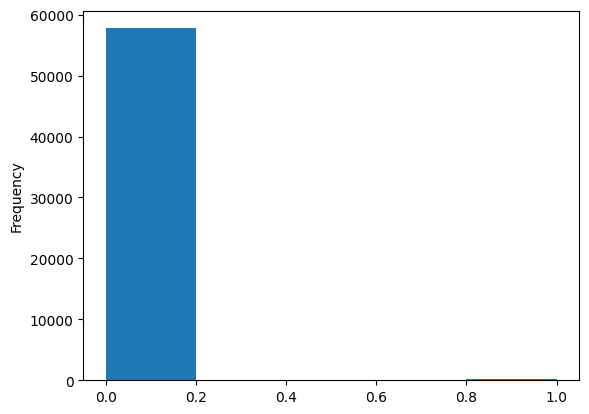

In [ ]:
total['univ_transfer'].plot.hist(bins=5)

<Axes: ylabel='Frequency'>

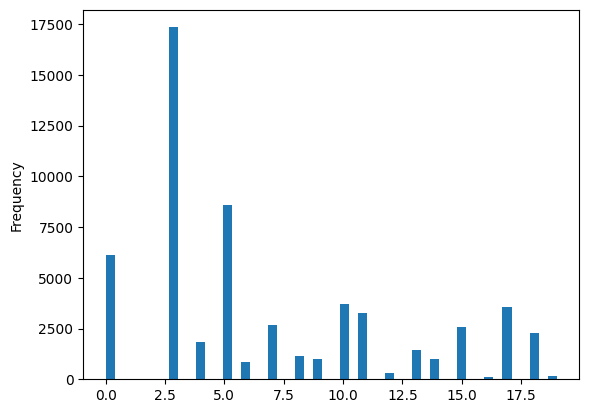

In [ ]:
total['univ_location'].plot.hist(bins=50)

<Axes: ylabel='last_salary'>

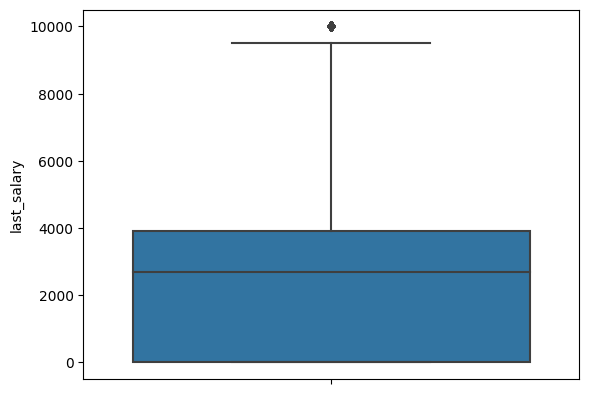

In [ ]:
sns.boxplot(y=total['last_salary'], data=total)

<Axes: ylabel='hope_salary'>

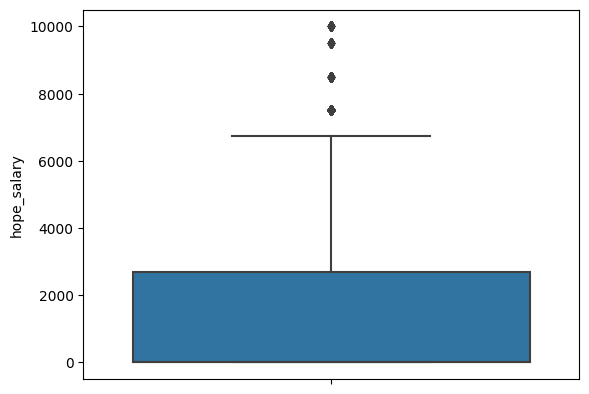

In [ ]:
sns.boxplot(y=total['hope_salary'], data=total)

<Axes: xlabel='address_seq1', ylabel='hischool_location_seq'>

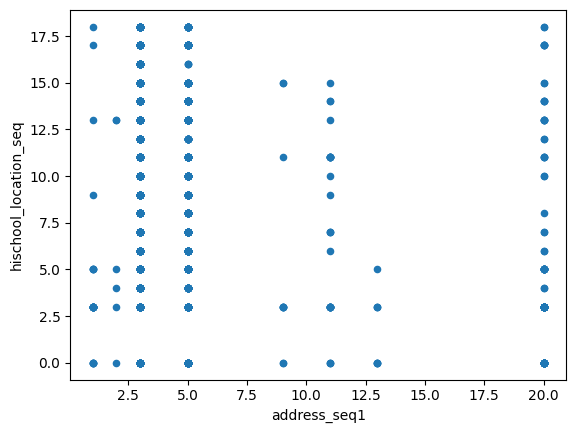

In [ ]:
total.plot(kind='scatter', x='address_seq1', y='hischool_location_seq')

<Axes: xlabel='address_seq1', ylabel='univ_location'>

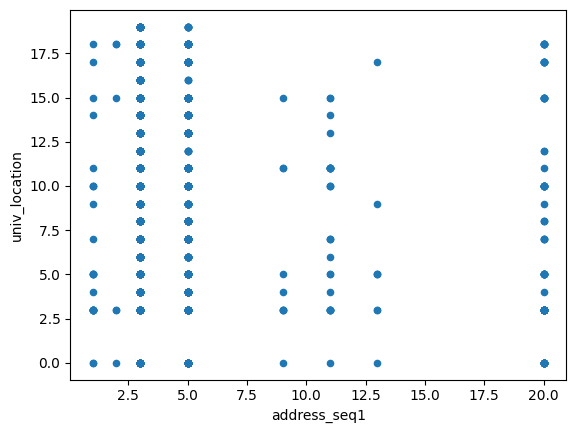

In [ ]:
total.plot(kind='scatter', x='address_seq1', y='univ_location')

<Axes: >

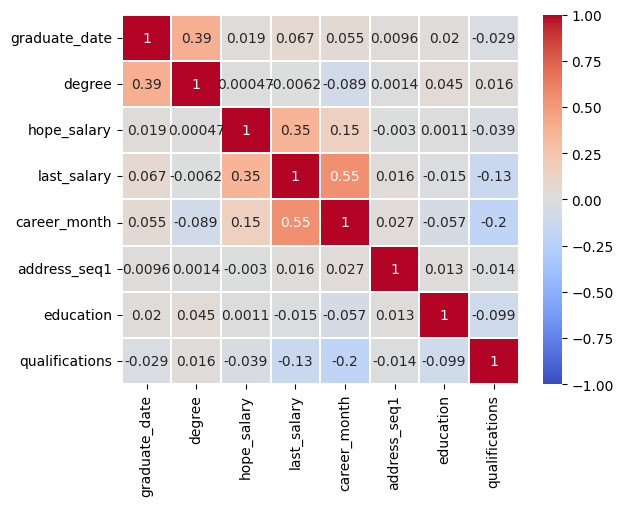

In [ ]:
total_tmp = total[['graduate_date','degree','hope_salary','last_salary', 'career_month', 'address_seq1', 'education', 'qualifications']]
sns.heatmap(total_tmp.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')

<Axes: >

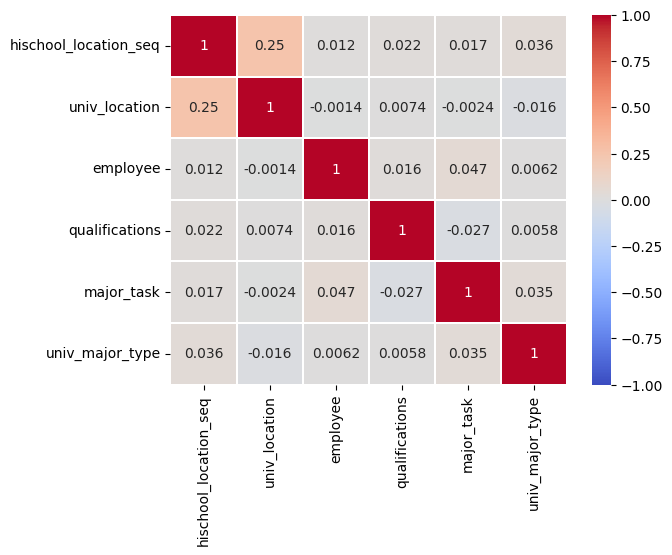

In [ ]:
total_tmp = total[['hischool_location_seq','univ_location','employee','qualifications', 'major_task', 'univ_major_type']]
sns.heatmap(total_tmp.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')

In [ ]:
total_tmp = total[['resume_seq','univ_major_type','company_type_seq', 'major_task']]
total_tmp

resume_seq  univ_major_type  company_type_seq  major_task
0         U00001                9               NaN           7
1         U00001                9               NaN           2
2         U00001                9               NaN           7
3         U00001                9               NaN           2
4         U00002                8               NaN           2
...          ...              ...               ...         ...
57941     U08481                9               2.0           2
57942     U08481                9               NaN           2
57943     U08482                9               NaN           2
57944     U08482                9               NaN           2
57945     U08482                9               2.0           2

[57946 rows x 4 columns]

In [ ]:
total['major_task'].value_counts()

2     54954
8      1906
7       797
1       248
9        21
10       15
6         5
Name: major_task, dtype: int64

In [ ]:
total['univ_major_type'].value_counts()

9     20616
3      7952
4      6068
19     4546
5      4339
0      3173
8      3119
10     2003
20      985
18      767
2       711
7       706
13      493
6       435
14      392
15      376
17      323
23      292
11      218
16      143
12      117
22      101
21       71
Name: univ_major_type, dtype: int64

In [ ]:
total['univ_location'].value_counts()

3     17349
5      8584
0      6133
10     3693
17     3574
11     3254
7      2672
15     2553
18     2274
4      1853
13     1465
8      1146
9      1016
14      990
6       843
12      296
19      150
16      101
Name: univ_location, dtype: int64

In [ ]:
total['address_seq1'].value_counts()

3.0     56270
5.0      1475
20.0      115
11.0       29
1.0        27
9.0        10
13.0        8
2.0         6
Name: address_seq1, dtype: int64

In [ ]:
total[total['address_seq1'] == total['univ_location']].count()

resume_seq               17049
reg_date                 17049
updated_date             17049
degree                   17049
graduate_date            17049
hope_salary              17049
last_salary              17049
text_keyword_x           16633
job_code_seq1            17049
job_code_seq2              849
job_code_seq3              275
career_month             17049
career_job_code          16036
certificate_contents     11709
hischool_type_seq        17049
hischool_special_type    17049
hischool_nation          17049
hischool_gender          17049
hischool_location_seq    17049
univ_type_seq1           17049
univ_type_seq2           17049
univ_transfer            17049
univ_location            17049
univ_major                3187
univ_sub_major             810
univ_major_type          17049
univ_score               17049
recruitment_seq          17049
address_seq1             17049
address_seq2               236
address_seq3                21
career_end               17049
career_s

In [ ]:
total[(total['address_seq1'] - total['univ_location']<5) & (total['address_seq1'] - total['univ_location']>-5)].count()

resume_seq               37266
reg_date                 37266
updated_date             37266
degree                   37266
graduate_date            37266
hope_salary              37266
last_salary              37266
text_keyword_x           36446
job_code_seq1            37266
job_code_seq2             1870
job_code_seq3              693
career_month             37266
career_job_code          35190
certificate_contents     26547
hischool_type_seq        37266
hischool_special_type    37266
hischool_nation          37266
hischool_gender          37266
hischool_location_seq    37266
univ_type_seq1           37266
univ_type_seq2           37266
univ_transfer            37266
univ_location            37266
univ_major                8819
univ_sub_major            1832
univ_major_type          37266
univ_score               37266
recruitment_seq          37266
address_seq1             37266
address_seq2               515
address_seq3                44
career_end               37266
career_s

In [ ]:
total[(total['address_seq1'] - total['hischool_location_seq']<=6) & (total['address_seq1'] - total['hischool_location_seq']>=-6)].count()

resume_seq               44599
reg_date                 44599
updated_date             44599
degree                   44599
graduate_date            44599
hope_salary              44599
last_salary              44599
text_keyword_x           43580
job_code_seq1            44599
job_code_seq2             2458
job_code_seq3              969
career_month             44599
career_job_code          41990
certificate_contents     32108
hischool_type_seq        44599
hischool_special_type    44599
hischool_nation          44599
hischool_gender          44599
hischool_location_seq    44599
univ_type_seq1           44599
univ_type_seq2           44599
univ_transfer            44599
univ_location            44599
univ_major               10313
univ_sub_major            2070
univ_major_type          44599
univ_score               44599
recruitment_seq          44599
address_seq1             44599
address_seq2               665
address_seq3                62
career_end               44599
career_s

In [ ]:
total['degree'].value_counts()

4    50468
3     3537
5     2202
2     1688
6       51
Name: degree, dtype: int64

In [ ]:
resume_train_df['degree'].value_counts()

4    7453
3     463
5     349
2     211
6       6
Name: degree, dtype: int64

In [ ]:
recruitment_train_df['education'].value_counts()

3    2862
4    2188
2    1644
6       1
Name: education, dtype: int64

In [ ]:
total[(total['education'] - total['degree']==-2)& (total['degree']==5)].count()

resume_seq               844
reg_date                 844
updated_date             844
degree                   844
graduate_date            844
hope_salary              844
last_salary              844
text_keyword_x           837
job_code_seq1            844
job_code_seq2             42
job_code_seq3             35
career_month             844
career_job_code          811
certificate_contents     631
hischool_type_seq        844
hischool_special_type    844
hischool_nation          844
hischool_gender          844
hischool_location_seq    844
univ_type_seq1           844
univ_type_seq2           844
univ_transfer            844
univ_location            844
univ_major               197
univ_sub_major            24
univ_major_type          844
univ_score               844
recruitment_seq          844
address_seq1             844
address_seq2              13
address_seq3               0
career_end               844
career_start             844
check_box_keyword        844
education     

# 데이터 전처리

In [ ]:
from surprise import Reader

In [ ]:
total['rating'].min(), total['rating'].max()

(1, 78)

In [ ]:
reader = Reader(rating_scale=(total['rating'].min(), total['rating'].max()))

In [ ]:
reader

# Dataset

In [ ]:
from surprise import Dataset

In [ ]:
total.columns

Index(['resume_seq', 'reg_date', 'updated_date', 'degree', 'graduate_date',
       'hope_salary', 'last_salary', 'text_keyword_x', 'job_code_seq1',
       'job_code_seq2', 'job_code_seq3', 'career_month', 'career_job_code',
       'certificate_contents', 'hischool_type_seq', 'hischool_special_type',
       'hischool_nation', 'hischool_gender', 'hischool_location_seq',
       'univ_type_seq1', 'univ_type_seq2', 'univ_transfer', 'univ_location',
       'univ_major', 'univ_sub_major', 'univ_major_type', 'univ_score',
       'recruitment_seq', 'address_seq1', 'address_seq2', 'address_seq3',
       'career_end', 'career_start', 'check_box_keyword', 'education',
       'major_task', 'qualifications', 'text_keyword_y', 'company_type_seq',
       'supply_kind', 'employee', 'rating'],
      dtype='object')

In [ ]:
cols = ['resume_seq', 'recruitment_seq', 'rating']
dataset = Dataset.load_from_df(total[cols], reader)

# train_test_split

In [ ]:
from surprise.model_selection import train_test_split

In [ ]:
trainset, testset = train_test_split(dataset, test_size=0.25, random_state=0)

# SVD 행렬 분해 기법을 통한 추천

## 모델 생성

In [ ]:
from surprise import SVD

In [ ]:
# 수행 시마다 동일한 결과를 도출하기 위해 random_state 설정
algo = SVD(n_factors=50, random_state=0)

## 학습

In [ ]:
# 학습 데이터 세트로 학습하고 나서 테스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)

## 예측

In [ ]:
predictions = algo.test(testset)

In [ ]:
predictions[0]

Prediction(uid='U07641', iid='R06145', r_ui=22.0, est=21.594031019911633, details={'was_impossible': False})

In [ ]:
# uid: 사용자 아이디
# iid: 아이템 아이디
# r_ui: 실제 평점
# est: 예측 평점
# was_impossible: False(예측할 수 있음), True(예측할 수 없음)

In [ ]:
predictions[0].est, testset[0]

(21.594031019911633, ('U07641', 'R06145', 22.0))

## 평가

In [ ]:
from surprise import accuracy

In [ ]:
accuracy.rmse(predictions)

RMSE: 3.6234


3.6233582855115802

# Surprise를 이용한 개인화 직업 추천 시스템

## 전체 데이터를 학습 데이터로 생성

In [ ]:
full_trainset = dataset.build_full_trainset()

## 모델 생성

In [ ]:
algo = SVD(n_epochs=20, n_factors=50, random_state=0)

## 학습

In [ ]:
algo.fit(full_trainset)

## 추천

In [ ]:
total.head(2)

resume_seq    reg_date updated_date  degree  graduate_date  hope_salary  \
0     U00001  2019-12-27   2020-02-01       4           2009       1500.0   
1     U00001  2019-12-27   2020-02-01       4           2009       1500.0   

   last_salary text_keyword_x job_code_seq1 job_code_seq2  ... career_start  \
0       1500.0           디자이너   재료·화학·섬유·의복           NaN  ...            0   
1       1500.0           디자이너   재료·화학·섬유·의복           NaN  ...            0   

   check_box_keyword education major_task  qualifications text_keyword_y  \
0               2507         4          7               1            NaN   
1          2507;2707         3          2               2            NaN   

  company_type_seq supply_kind  employee  rating  
0              NaN         NaN       NaN      12  
1              NaN         NaN       NaN       6  

[2 rows x 42 columns]

In [ ]:
total[total['resume_seq']=='U00001'].head()

resume_seq    reg_date updated_date  degree  graduate_date  hope_salary  \
0     U00001  2019-12-27   2020-02-01       4           2009       1500.0   
1     U00001  2019-12-27   2020-02-01       4           2009       1500.0   
2     U00001  2019-12-27   2020-02-01       4           2009       1500.0   
3     U00001  2019-12-27   2020-02-01       4           2009       1500.0   

   last_salary text_keyword_x job_code_seq1 job_code_seq2  ... career_start  \
0       1500.0           디자이너   재료·화학·섬유·의복           NaN  ...            0   
1       1500.0           디자이너   재료·화학·섬유·의복           NaN  ...            0   
2       1500.0           디자이너   재료·화학·섬유·의복           NaN  ...            0   
3       1500.0           디자이너   재료·화학·섬유·의복           NaN  ...            0   

   check_box_keyword education major_task  qualifications text_keyword_y  \
0               2507         4          7               1            NaN   
1          2507;2707         3          2               2            NaN   
2               2507         4          7               1            NaN   
3     2507;2707;2799         3          2               2            NaN   

  company_type_seq supply_kind  employee  rating  
0              NaN         NaN       NaN      12  
1              NaN         NaN       NaN       6  
2              NaN         NaN       NaN       8  
3              NaN         NaN       NaN      16  

[4 rows x 42 columns]

In [ ]:
ISBNs = total[total['resume_seq']=='U00001']['recruitment_seq']

In [ ]:
print(len(ISBNs))
print(type(ISBNs))

4
<class 'pandas.core.series.Series'>


In [ ]:
len(ISBNs[ISBNs=='R02946']), ISBNs[ISBNs=='R02946'].count()

(0, 0)

In [ ]:
print(f"R02946: {len(ISBNs[ISBNs=='R02946'])} / R05210: {len(ISBNs[ISBNs=='R05210'])}")

R02946: 0 / R05210: 1


In [ ]:
if ISBNs[ISBNs=='R02946'].count() == 0:
  print('사용자 아이디 U00001는 ISBN ''R02946''의 평점 없음')

사용자 아이디 U00001는 ISBN R02946의 평점 없음


In [ ]:
# 공고에 대한 상세 속성 정보 DataFrame 로딩
total[total['recruitment_seq']=='R02946']

resume_seq    reg_date updated_date  degree  graduate_date  hope_salary  \
9         U00002  2020-04-24   2020-04-29       4           2005          0.0   
19253     U02825  2016-09-14   2020-05-19       4           2009          0.0   
29184     U04355  2012-08-24   2020-04-07       4           2005          0.0   
32088     U04764  2011-04-05   2020-02-11       4           2009          0.0   
55099     U08029  2018-10-03   2020-05-15       4           2008          0.0   
57435     U08393  2017-03-19   2020-01-19       4           2008          0.0   

       last_salary                  text_keyword_x job_code_seq1  \
9              0.0                            디자이너   재료·화학·섬유·의복   
19253       3300.0                     의상디자인의상디자이너   재료·화학·섬유·의복   
29184       4700.0                           패션디자인   재료·화학·섬유·의복   
32088          0.0                           패션디자인   재료·화학·섬유·의복   
55099       2700.0  디자이너;여성복;스타일팀;경력;영캐주얼;영밸류;영캐릭터   재료·화학·섬유·의복   
57435       4300.0                          여성복디자인   재료·화학·섬유·의복   

      job_code_seq2  ... career_start  check_box_keyword education major_task  \
9               NaN  ...            0          2507;2707         3          2   
19253           NaN  ...            0          2507;2707         3          2   
29184           NaN  ...            0          2507;2707         3          2   
32088           NaN  ...            0          2507;2707         3          2   
55099           NaN  ...            0          2507;2707         3          2   
57435           NaN  ...            0          2507;2707         3          2   

       qualifications text_keyword_y company_type_seq supply_kind  employee  \
9                   1            NaN              NaN         NaN       NaN   
19253               1            NaN              NaN         NaN       NaN   
29184               1            NaN              NaN         NaN       NaN   
32088               1            NaN              NaN         NaN       NaN   
55099               1            NaN              NaN         NaN       NaN   
57435               1            NaN              NaN         NaN       NaN   

       rating  
9           6  
19253       6  
29184       6  
32088       6  
55099       6  
57435       6  

[6 rows x 42 columns]

## 추천 결과

In [ ]:
#uid: 사용자 아이디
#iid: 아이탬

In [ ]:
uid = str('U00001')
iid = str('R02946')

pred = algo.predict(uid, iid, verbose=True)

user: U00001     item: R02946     r_ui = None   est = 10.09   {'was_impossible': False}


In [ ]:
pred

Prediction(uid='U00001', iid='R02946', r_ui=None, est=10.086134121807458, details={'was_impossible': False})

In [ ]:
recommandes = []
for resume_seq in apply_matrix.index:
  recommand = []
  for item in apply_matrix.columns[1:]:
    uid = str(resume_seq)
    iid = str(item)
    pred = algo.predict(uid, iid, verbose=False)
    recommand.append(pred.est)
  recommandes.append(recommand)
  print(resume_seq)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
U03483
U03484
U03485
U03486
U03487
U03488
U03489
U03490
U03491
U03492
U03493
U03494
U03495
U03496
U03497
U03498
U03499
U03500
U03501
U03502
U03503
U03504
U03505
U03506
U03507
U03508
U03509
U03510
U03511
U03512
U03513
U03514
U03515
U03516
U03517
U03518
U03519
U03520
U03521
U03522
U03523
U03524
U03525
U03526
U03527
U03528
U03529
U03530
U03531
U03532
U03533
U03534
U03535
U03536
U03537
U03538
U03539
U03540
U03541
U03542
U03543
U03544
U03545
U03546
U03547
U03548
U03549
U03550
U03551
U03552
U03553
U03554
U03555
U03556
U03557
U03558
U03559
U03560
U03561
U03562
U03563
U03564
U03565
U03566
U03567
U03568
U03569
U03570
U03571
U03572
U03573
U03574
U03575
U03576
U03577
U03578
U03579
U03580
U03581
U03582
U03583
U03584
U03585
U03586
U03587
U03588
U03589
U03590
U03591
U03592
U03593
U03594
U03595
U03596
U03597
U03598
U03599
U03600
U03601
U03602
U03603
U03604
U03605
U03606
U03607
U03608
U03609
U03610
U03611
U03612
U03613
U03614
U03615
U03616
U03617
U03618
U03619
U0362

### 예측평점

In [ ]:
pred.est

11.44844544165883

# 회사 최소 조건

In [ ]:
resume_c = resume_train_df.copy()
recruitment_c = recruitment_train_df.copy()

In [ ]:
# 'resume_seq' 열을 기준으로 정렬
resume_c = resume_c.sort_values(by='resume_seq')
# 인덱스를 순차적으로 변경
resume_c['resume_seq'] = [f'U{i:05}' for i in range(1, len(resume_c) + 1)]
resume_c = resume_c.set_index('resume_seq')

# 'resume_seq' 열을 기준으로 정렬
recruitment_c = recruitment_c.sort_values(by='recruitment_seq')
# 인덱스를 순차적으로 변경
recruitment_c['recruitment_seq'] = [f'R{i:05}' for i in range(1, len(recruitment_c) + 1)]
recruitment_c = recruitment_c.set_index('recruitment_seq')

In [ ]:
resume_c = resume_c[['degree']]
recruitment_c = recruitment_c[['education']]

In [ ]:
apply_item_matrix_new = []
count = 0
# 초등학생들 ^^
tem_6 = [] # U05886이 6학년
tem_5 = [] # U08422이 5학년
tem_4 = [] # U04600이 4학년
tem_3 = [] # U03400이 3학년
tem_2 = [] # U04220이 2학년

for recruitment_seq in range(len(recruitment_c)): #
  if resume_c.loc['U05886']['degree'] < recruitment_c.iloc[recruitment_seq]['education']:
        a = False
  else:
        a = True
  tem_6.append(a)

for recruitment_seq in range(len(recruitment_c)):
  if resume_c.loc['U08422']['degree'] < recruitment_c.iloc[recruitment_seq]['education']:
        a = False
  else:
        a = True
  tem_5.append(a)

for recruitment_seq in range(len(recruitment_c)):
  if resume_c.loc['U04600']['degree'] < recruitment_c.iloc[recruitment_seq]['education']:
        a = False
  else:
        a = True
  tem_4.append(a)

for recruitment_seq in range(len(recruitment_c)):
  if resume_c.loc['U03400']['degree'] < recruitment_c.iloc[recruitment_seq]['education']:
        a = False
  else:
        a = True
  tem_3.append(a)

for recruitment_seq in range(len(recruitment_c)):
  if resume_c.loc['U04220']['degree'] < recruitment_c.iloc[recruitment_seq]['education']:
        a = False
  else:
        a = True
  tem_2.append(a)

# apply_item_matrix의 인덱스(=resume_seq)와 컬럼(=recruitment_seq)을 뽑아냄
for resume_seq in range(len(resume_c)):
    if resume_c.iloc[resume_seq]['degree'] == 6:
      apply_item_matrix_new.append(tem_6)
    elif resume_c.iloc[resume_seq]['degree'] == 5:
      apply_item_matrix_new.append(tem_5)
    elif resume_c.iloc[resume_seq]['degree'] == 4:
      apply_item_matrix_new.append(tem_4)
    elif resume_c.iloc[resume_seq]['degree'] == 3:
      apply_item_matrix_new.append(tem_3)
    else:
      apply_item_matrix_new.append(tem_2)

# 새로운 DataFrame 생성
apply_item_matrix_new = pd.DataFrame(apply_item_matrix_new, index=apply_matrix.index, columns=apply_matrix.columns)
apply_item_matrix_new

recruitment_seq  R00001  R00002  R00003  R00004  R00005  R00006  R00007  \
resume_seq                                                                
U00001             True    True    True    True    True    True    True   
U00002             True    True    True    True    True    True    True   
U00003             True    True    True    True    True    True    True   
U00004             True    True    True    True    True    True    True   
U00005             True    True    True    True    True    True    True   
...                 ...     ...     ...     ...     ...     ...     ...   
U08478             True    True    True    True    True    True    True   
U08479             True    True    True    True    True   False    True   
U08480             True    True    True    True    True    True    True   
U08481             True    True    True    True    True    True    True   
U08482             True    True    True    True    True    True    True   

recruitment_seq  R00008  R00009  R00010  ...  R06686  R06687  R06688  R06689  \
resume_seq                               ...                                   
U00001             True    True    True  ...    True    True    True    True   
U00002             True    True    True  ...    True    True    True    True   
U00003             True    True    True  ...    True    True    True    True   
U00004             True    True    True  ...    True    True    True    True   
U00005             True    True    True  ...    True    True    True    True   
...                 ...     ...     ...  ...     ...     ...     ...     ...   
U08478             True    True    True  ...    True    True    True    True   
U08479             True    True    True  ...    True    True    True    True   
U08480             True    True    True  ...    True    True    True    True   
U08481             True    True    True  ...    True    True    True    True   
U08482             True    True    True  ...    True    True    True    True   

recruitment_seq  R06690  R06691  R06692  R06693  R06694  R06695  
resume_seq                                                       
U00001             True    True    True    True    True    True  
U00002             True    True    True    True    True    True  
U00003             True    True    True    True    True    True  
U00004             True    True    True    True    True    True  
U00005             True    True    True    True    True    True  
...                 ...     ...     ...     ...     ...     ...  
U08478             True    True    True    True    True    True  
U08479             True    True    True   False   False    True  
U08480             True    True    True    True    True    True  
U08481             True    True    True    True    True    True  
U08482             True    True    True    True    True    True  

[8482 rows x 6695 columns]

# pred 결과 도출

In [ ]:
sort_user_list = []
applied_jobs = []

for idx, user in enumerate(apply_matrix.index):
    # 해당 사용자가 지원한 채용 공고
    applied_job = apply_train_df[apply_train_df['resume_seq'] == user]['recruitment_seq'].values
    applied_jobs.append([user, applied_job])

In [ ]:
recommands = np.array(recommandes)

In [ ]:
# 이미 지원한 채용 공고 제외하고 추천
recommendations = []

for idx, user in enumerate(apply_matrix.index):
  re_applied_jobs = []
  # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
  sorted_job_indices = recommands[idx].argsort()[::-1]
  for idxx, j in enumerate(sorted_job_indices):
    if(len(re_applied_jobs) >= 5):
      break
    else:
      job = apply_matrix.columns[j]
      if (job not in applied_jobs[idx][1] and apply_item_matrix_new.loc[user].loc[job] and (job not in re_applied_jobs)):
        re_applied_jobs.append(job)
        recommendations.append([user, job])

In [ ]:
# sample_submission.csv 형태로 DataFrame 생성
top_recommendations = pd.DataFrame(recommendations, columns=['resume_seq', 'recruitment_seq'])

top_recommendations.to_csv('./H_submit.csv', index=False)